In [1]:
%%capture
# CODE for running this notebook in google colab: please upload your kaggle.json API to /content/ to make this work
! pip install kaggle ; mkdir ~/.kaggle ; cp /content/kaggle.json ~/.kaggle ; kaggle datasets download moltean/fruits ; unzip fruits.zip ; mkdir /content/fruits-360_dataset/fruits-360/preview ;  



In [1]:
# install modules
!  pip install visualkeras ; ! pip install ThreadedFileLoader # module for CNN visualization


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In this section of the project I will use the VGG16 Architecture to make predictions again, this architecture is simple and widely used, It's not state of the art but it should be good enough to experiment with.

## Loading the data and Transfer Learning test (VGG16)

In [2]:
# Loading the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import os 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.applications.xception import decode_predictions
import visualkeras
from keras import models,layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input


# modules necessary for loading the preview data augmentated images
from ThreadedFileLoader.ThreadedFileLoader import *
from mpl_toolkits.axes_grid1 import ImageGrid


# loading image modules
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#matplotlib styles
plt.style.use(['ggplot'])

In [3]:
conv_base = keras.applications.vgg16.VGG16(
                          weights="imagenet",
                          include_top=False,
                          input_shape=(100, 100, 3))

2021-12-14 07:08:27.407686: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 07:08:27.512762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 07:08:27.512982: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-14 07:08:27.514390: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

58900480/58889256 [==============================] - 6s 0us/step


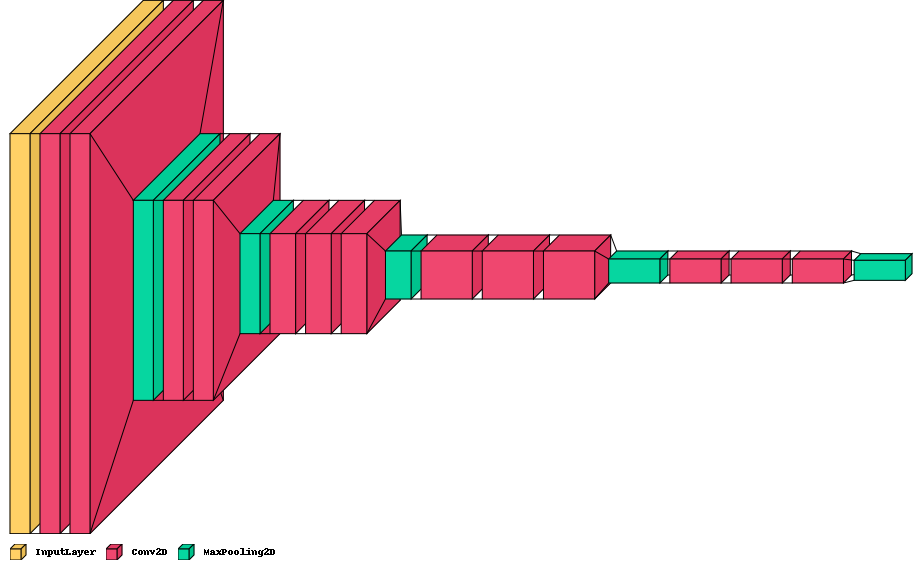

In [4]:
visualkeras.layered_view(conv_base).show()
visualkeras.layered_view(conv_base,legend=True)

In [5]:
conv_base.summary() # Print a Summary of the VGG-16 Architecture 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

## Extracting features using this pretrained convolutional base

In [7]:
#train_dir = '/content/fruits-360_dataset/fruits-360/Training'
#test_dir = '/content/fruits-360_dataset/fruits-360/Test'
test_dir = 'data/fruits-360/Test'
train_dir =  'data/fruits-360/Training'

In [8]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    #split for validation
    validation_split=0.2)

train_ds = train_gen.flow_from_directory(
    train_dir,
    target_size=(100, 100),
    batch_size=32,
    shuffle=True,# IMPORTANT , shuffle the dataset
    subset='training'# set as training data
)




Found 54190 images belonging to 131 classes.


In [9]:

val_ds = train_gen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(100, 100),
    batch_size=32,
    subset='validation') # set as validation data


Found 13502 images belonging to 131 classes.


In [10]:

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    shuffle=True)

Found 22688 images belonging to 131 classes.


Here we define the model to be executed, similar to XCeption, with layers representing the following: 

- Flatten() : flattens the 3d tensor into a 2D Shape

In [11]:
def build_model(alpha=0.05):
    conv_base = keras.applications.vgg16.VGG16(
                            weights="imagenet",
                            include_top=False, # include the densely connected classifier on top of the network
                            input_shape=(100, 100, 3)) 
    
    conv_base.trainable = False # Freeze the convolutional base 

    model = models.Sequential()
    
    model.add(conv_base)
    model.add(layers.Flatten())
    
    # model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
    # model.add(layers.Dropout(0.5))

    model.add(layers.Dense(131, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=alpha),       
                loss='categorical_crossentropy',
                metrics=['accuracy']
                )
    
    return model                 

In [ ]:
alpha= 0.001

model = build_model(alpha=alpha)
history = model.fit(train_ds,
                        epochs=10,
                        batch_size=20,
                        validation_data=val_ds)

Epoch 1/10
1694/1694 [==============================] - 51s 30ms/step - loss: 3.3058 - accuracy: 0.4911 - val_loss: 2.1678 - val_accuracy: 0.8132
Epoch 2/10
1694/1694 [==============================] - 51s 30ms/step - loss: 1.4681 - accuracy: 0.9106 - val_loss: 1.1296 - val_accuracy: 0.8969
Epoch 3/10
1694/1694 [==============================] - 48s 29ms/step - loss: 0.7654 - accuracy: 0.9614 - val_loss: 0.6790 - val_accuracy: 0.9245
Epoch 4/10
1694/1694 [==============================] - 48s 28ms/step - loss: 0.4462 - accuracy: 0.9791 - val_loss: 0.4609 - val_accuracy: 0.9393
Epoch 5/10
1694/1694 [==============================] - 49s 29ms/step - loss: 0.2827 - accuracy: 0.9874 - val_loss: 0.3340 - val_accuracy: 0.9515
Epoch 6/10
1694/1694 [==============================] - 50s 29ms/step - loss: 0.1904 - accuracy: 0.9913 - val_loss: 0.2626 - val_accuracy: 0.9550
Epoch 7/10
1694/1694 [==============================] - 49s 29ms/step - loss: 0.1350 - accuracy: 0.9932 - val_loss: 0.2140 -

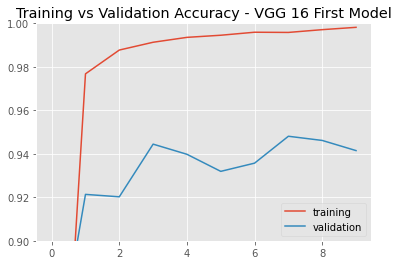

In [ ]:
plt.plot(history.history['accuracy'],label='training')
plt.title("Training vs Validation Accuracy - VGG 16 First Model")
plt.plot(history.history['val_accuracy'],label='validation')
plt.ylim(0.9, 1) # zoom to look the graphs more closely
plt.legend()

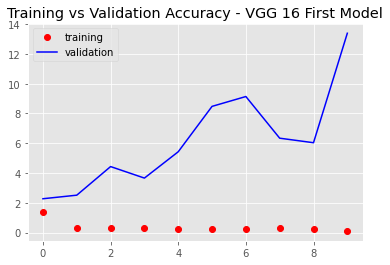

In [ ]:
plt.plot(history.history['loss'],'ro',label='training')
plt.title("Training vs Validation Accuracy - VGG 16 First Model")
plt.plot(history.history['val_loss'],'b',label='validation')


plt.legend()

In [ ]:
model.evaluate(test_ds)



709/709 [==============================] - 25s 36ms/step - loss: 0.3685 - accuracy: 0.9200


[0.3684837520122528, 0.91995769739151]

91 % accuracy on the test dataset ! That's really impressive considering no parameter has been tuned yet. 

## Fine-tuning this model using keras

Fine-tuning is a widely used technique for model reuse, it basically allows for more abstract representations of the reused model, and with that allow it to be more relevant for the current problem. 

This code allows the freezing of all layers until the fourth to the last:
```python
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False
```

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

Basically, it would freeze all the layers up to `black4_conv2` , and allows to make  the last 4 layers `block5_conv1`, `block5_conv2`, and `block5_conv3` trainable.

In [ ]:
def build_model(alpha=0.05):
    conv_base = keras.applications.vgg16.VGG16(
                            weights="imagenet",
                            include_top=False, # include the densely connected classifier on top of the network
                            input_shape=(100, 100, 3)) 
    

    conv_base.trainable = True

    for layer in conv_base.layers[:-4]:
        layer.trainable = False # this code allows

    model = models.Sequential()
    
    model.add(conv_base)
    model.add(layers.Flatten())
    
    # model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
    # model.add(layers.Dropout(0.5))

    model.add(layers.Dense(131, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=alpha),       
                loss='categorical_crossentropy',
                metrics=['accuracy']
                )
    
    return model                 

In [ ]:
alpha= 0.001

model = build_model(alpha=alpha)
history = model.fit(train_ds,
                        epochs=10,
                        batch_size=32,
                        validation_data=val_ds)

Epoch 1/10
1694/1694 [==============================] - 56s 33ms/step - loss: 1.3685 - accuracy: 0.7237 - val_loss: 2.2764 - val_accuracy: 0.8316
Epoch 2/10
1694/1694 [==============================] - 56s 33ms/step - loss: 0.3074 - accuracy: 0.9768 - val_loss: 2.5156 - val_accuracy: 0.9213
Epoch 3/10
1694/1694 [==============================] - 55s 32ms/step - loss: 0.3212 - accuracy: 0.9877 - val_loss: 4.4356 - val_accuracy: 0.9202
Epoch 4/10
1694/1694 [==============================] - 55s 33ms/step - loss: 0.2928 - accuracy: 0.9913 - val_loss: 3.6631 - val_accuracy: 0.9445
Epoch 5/10
1694/1694 [==============================] - 55s 32ms/step - loss: 0.2541 - accuracy: 0.9936 - val_loss: 5.4297 - val_accuracy: 0.9398
Epoch 6/10
1694/1694 [==============================] - 53s 32ms/step - loss: 0.2783 - accuracy: 0.9945 - val_loss: 8.4774 - val_accuracy: 0.9319
Epoch 7/10
1694/1694 [==============================] - 55s 33ms/step - loss: 0.2551 - accuracy: 0.9959 - val_loss: 9.1381 -

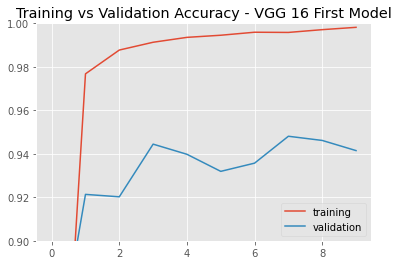

In [ ]:
plt.plot(history.history['accuracy'],label='training')
plt.title("Training vs Validation Accuracy - VGG 16 First Model")
plt.plot(history.history['val_accuracy'],label='validation')
plt.ylim(0.9, 1) # zoom to look the graphs more closely
plt.legend()

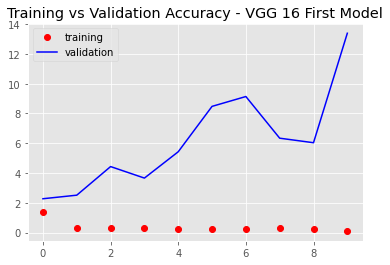

In [ ]:
plt.plot(history.history['loss'],'ro',label='training')
plt.title("Training vs Validation Accuracy - VGG 16 First Model")
plt.plot(history.history['val_loss'],'b',label='validation')


plt.legend()

In [ ]:
model.evaluate(test_ds)


709/709 [==============================] - 17s 23ms/step - loss: 10.6204 - accuracy: 0.9388


[10.6204252243042, 0.9387782216072083]

The accuracy on the test dataset went up by $2\%$ , however the loss is quite high $[10.620]$, this should be improved with dropout regularization, adding more layers, tuning the learning rate, and adding data augmentation.

### Hyperparameter Tuning for VGG16

#### Tuning learning rate

Considering we are finetuning the last layers of VGG, a very low learning rate should be considered, as per deep learning for computer vision with Python by Fracois Chollet:

>The reason for using a low learning rate is that you want to limit the magnitude of the modifications you make to the representations of the three layers you’re fine-tuning. Updates that are too large may harm these representations.


In [ ]:
def build_model(alpha=0.05):
    conv_base = keras.applications.vgg16.VGG16(
                            weights="imagenet",
                            include_top=False, # include the densely connected classifier on top of the network
                            input_shape=(100, 100, 3)) 
    

    conv_base.trainable = True

    for layer in conv_base.layers[:-4]:
        layer.trainable = False # this code allows

    model = models.Sequential()
    
    model.add(conv_base)
    model.add(layers.Flatten())


    model.add(layers.Dense(131, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=alpha),       
                loss='categorical_crossentropy',
                metrics=['accuracy']
                )
    
    return model            

In [ ]:
scores = {}



for lr in [1e-5,1e-4,0.001]:
    print(lr)

    model = build_model(alpha=lr)
    history = model.fit(train_ds, epochs=10,batch_size=32, validation_data=val_ds)
    scores[lr] = history.history

    print()
    print()

1e-05
Epoch 1/10
1694/1694 [==============================] - 68s 39ms/step - loss: 0.7487 - accuracy: 0.8622 - val_loss: 0.1090 - val_accuracy: 0.9647 loss: 0.7514 - accuracy
Epoch 2/10
1694/1694 [==============================] - 65s 38ms/step - loss: 0.0029 - accuracy: 0.9995 - val_loss: 0.0718 - val_accuracy: 0.9740
Epoch 3/10
1694/1694 [==============================] - 64s 38ms/step - loss: 9.2835e-04 - accuracy: 0.9998 - val_loss: 0.0478 - val_accuracy: 0.9810
Epoch 4/10
1694/1694 [==============================] - 66s 39ms/step - loss: 4.2618e-04 - accuracy: 0.9999 - val_loss: 0.0590 - val_accuracy: 0.9807
Epoch 5/10
1694/1694 [==============================] - 65s 39ms/step - loss: 2.4485e-04 - accuracy: 0.9999 - val_loss: 0.0556 - val_accuracy: 0.9805
Epoch 6/10
1694/1694 [==============================] - 64s 38ms/step - loss: 1.8913e-04 - accuracy: 0.9999 - val_loss: 0.1408 - val_accuracy: 0.9707
Epoch 7/10
1694/1694 [==============================] - 63s 37ms/step - loss: 

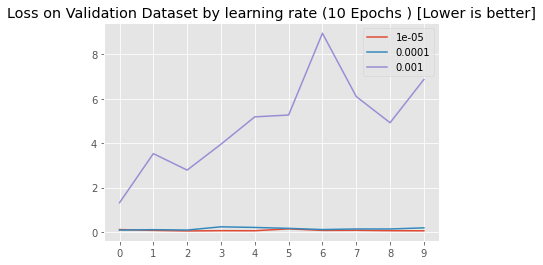

In [ ]:
for lr,hist in scores.items():
    plt.plot(hist['val_loss'],label=lr)

plt.title("Loss on Validation Dataset by learning rate (10 Epochs ) [Lower is better]")
plt.xticks(np.arange(10))

plt.legend()

`0.001` loss is quite high, hence it should be descarted.

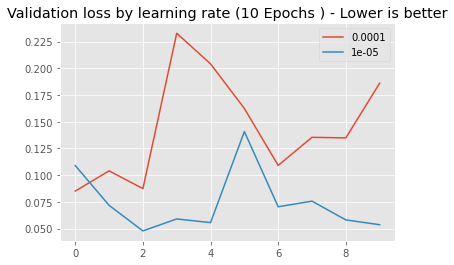

In [ ]:
hist = scores[1e-4]
plt.plot(hist['val_loss'], label=0.0001)


hist = scores[1e-5]
plt.plot(hist['val_loss'], label=0.00001)

plt.title("Validation loss by learning rate (10 Epochs ) - Lower is better")

plt.legend()

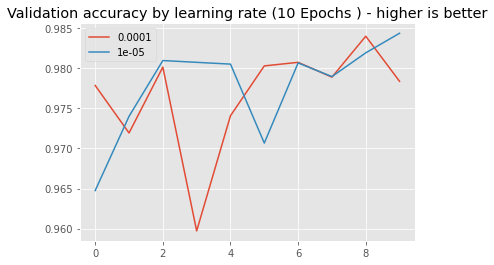

In [ ]:
hist = scores[1e-4]
plt.plot(hist['val_accuracy'], label=0.0001)


hist = scores[1e-5]
plt.plot(hist['val_accuracy'], label=0.00001)

plt.title("Validation accuracy by learning rate (10 Epochs ) - higher is better")

plt.legend()

The best accuracy was obtained with `1e-05`  ( `0.00001` in decimal numbers ) learning rate, as well as the best loss value, so this would be the learning rate moving forward.

### Adding More Layers

Adding more layers is done to increase the capacity of the network, and it's a classic way of building more powerful recurrent networks.

In [ ]:
def build_model(alpha=0.05,size_inner=256):
    conv_base = keras.applications.vgg16.VGG16(
                            weights="imagenet",
                            include_top=False, # include the densely connected classifier on top of the network
                            input_shape=(100, 100, 3)) 
    

    conv_base.trainable = True

    for layer in conv_base.layers[:-4]:
        layer.trainable = False # this code allows us to freeze all the layers except the last 4.
    model = models.Sequential()
    
    model.add(conv_base)
    model.add(layers.Flatten())
    
    model.add(layers.Dense(size_inner, activation='relu'))
    
    
    # model.add(layers.Dropout(0.5))

    model.add(layers.Dense(131, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=alpha),       
                loss='categorical_crossentropy',
                metrics=['accuracy']
                )
    
    return model                 

In [ ]:
alpha=1e-5


score={}

for size in [256,512,1024]:
    print(size)
    model = build_model(alpha=alpha,size_inner=size)
    history = model.fit(train_ds,epochs=10,validation_data=val_ds)
    score[size] = history.history
    print()
    print()

256
Epoch 1/10
1694/1694 [==============================] - 67s 39ms/step - loss: 0.9651 - accuracy: 0.8195 - val_loss: 0.1415 - val_accuracy: 0.9595
Epoch 2/10
1694/1694 [==============================] - 66s 39ms/step - loss: 0.0063 - accuracy: 0.9989 - val_loss: 0.0842 - val_accuracy: 0.9734
Epoch 3/10
1694/1694 [==============================] - 69s 41ms/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.0786 - val_accuracy: 0.9786
Epoch 4/10
1694/1694 [==============================] - 65s 38ms/step - loss: 8.4074e-04 - accuracy: 0.9998 - val_loss: 0.0795 - val_accuracy: 0.9784
Epoch 5/10
1694/1694 [==============================] - 65s 39ms/step - loss: 5.6385e-04 - accuracy: 0.9998 - val_loss: 0.0635 - val_accuracy: 0.9813
Epoch 6/10
1694/1694 [==============================] - 64s 38ms/step - loss: 4.2397e-04 - accuracy: 0.9999 - val_loss: 0.0815 - val_accuracy: 0.9788
Epoch 7/10
1694/1694 [==============================] - 65s 38ms/step - loss: 7.1337e-05 - accuracy: 1.0000 

- Visualizing the model:

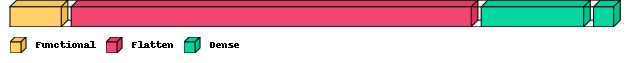

In [ ]:
visualkeras.layered_view(model).show()
visualkeras.layered_view(model,legend=True)

Text(0.5, 1.0, 'Validation Accuracy by inner size [10 Epochs] ')

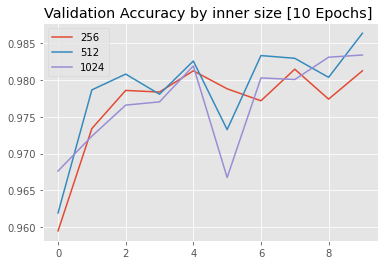

In [ ]:
for size,hist in score.items():
    plt.plot(hist['val_accuracy'],label=size)
plt.legend()
plt.title("Validation Accuracy by inner size [10 Epochs] ")

Text(0.5, 1.0, 'Validation Loss by inner size [10 Epochs] ')

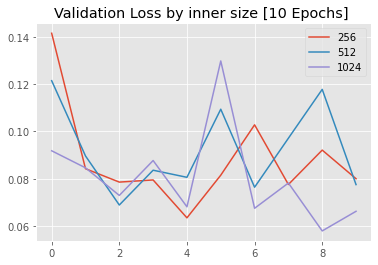

In [ ]:
for size,hist in score.items():
    plt.plot(hist['val_loss'],label=size)

plt.legend()
plt.title("Validation Loss by inner size [10 Epochs] ")

It seems like an inner layer size of 512 is the most ideal, both results of `1024` and `512` are extremely close, but 512 seems like the better balance between loss and accuracy.

<b> Chosen:```size_inner=512```</b>

### Adding Dropout and Regularization


Dropout helps "knocking" random units of the network, using a smaller neural network, and it could help to do a regularization effect.


The following code will add a new dropout layer:

```python
model.add(layers.Dropout(0.5))
```

In [37]:
def build_model(alpha=1e-5,size_inner=512,droprate=0.5):
    conv_base = keras.applications.vgg16.VGG16(
                            weights="imagenet",
                            include_top=False, # include the densely connected classifier on top of the network
                            input_shape=(100, 100, 3)) 
    

    conv_base.trainable = True

    for layer in conv_base.layers[:-4]:
        layer.trainable = False # this code allows us to freeze all the layers except the last 4.
    model = models.Sequential()
    
    model.add(conv_base)
    model.add(layers.Flatten())
    
    model.add(layers.Dense(size_inner, activation='relu'))
    
    # ADDING DROPOUT
    model.add(layers.Dropout(droprate))

    model.add(layers.Dense(131, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.RMSprop(learning_rate=alpha),       
                loss='categorical_crossentropy',
                metrics=['accuracy']
                )
    
    return model     

In [ ]:
learning_rate = 1e-5
size_inner=512


scores = {}

for droprate in [0.1, 0.2, 0.5]:
    print(droprate)

    model = build_model(
        alpha=learning_rate,
        size_inner=size_inner,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()


0.1
58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/10
1694/1694 [==============================] - 80s 41ms/step - loss: 0.9353 - accuracy: 0.8135 - val_loss: 0.1171 - val_accuracy: 0.9593
Epoch 2/10
1694/1694 [==============================] - 67s 40ms/step - loss: 0.0097 - accuracy: 0.9986 - val_loss: 0.0475 - val_accuracy: 0.9833
Epoch 3/10
1694/1694 [==============================] - 67s 39ms/step - loss: 0.0026 - accuracy: 0.9995 - val_loss: 0.0484 - val_accuracy: 0.9810
Epoch 4/10
1694/1694 [==============================] - 67s 40ms/step - loss: 0.0011 - accuracy: 0.9997 - val_loss: 0.0927 - val_accuracy: 0.9759
Epoch 5/10
1694/1694 [==============================] - 67s 39ms/step - loss: 5.1519e-04 - accuracy: 0.9999 - val_loss: 0.0344 - val_accuracy: 0.9859
Epoch 6/10
1694/1694 [==============================] - 67s 40ms/step - loss: 5.8855e-04 - accuracy: 0.9998 - val_loss: 0.0504 - val_accuracy: 0.9843
Epoch 7/10
1694/1694 [=========================

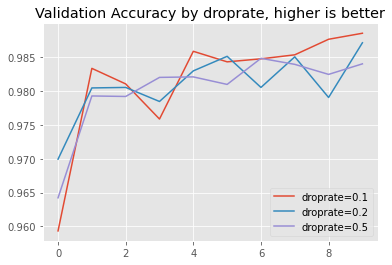

In [ ]:
for droprate, hist in scores.items():
    plt.plot(hist['val_accuracy'], label=('droprate=%s' % droprate))
plt.title("Validation Accuracy by droprate, higher is better")
plt.legend()


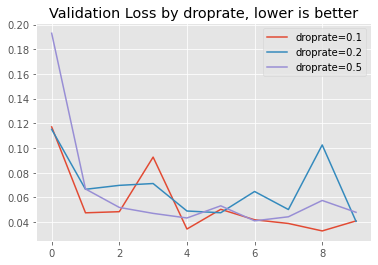

In [ ]:
for droprate, hist in scores.items():
    plt.plot(hist['val_loss'], label=('droprate=%s' % droprate))
plt.title("Validation Loss by droprate, lower is better")
plt.legend()


In [109]:
learning_rate = 1e-5
size_inner=512


scores = {}

for droprate in [0.2]:
    print(droprate)

    model = build_model(
        alpha=learning_rate,
        size_inner=size_inner,
        droprate=droprate
    )

    history = model.fit(train_ds, epochs=10, validation_data=val_ds)
    scores[droprate] = history.history

    print()
    print()

0.2
Epoch 1/10
1694/1694 [==============================] - 60s 35ms/step - loss: 1.1187 - accuracy: 0.7723 - val_loss: 0.1048 - val_accuracy: 0.9763
Epoch 2/10
1694/1694 [==============================] - 58s 34ms/step - loss: 0.0225 - accuracy: 0.9962 - val_loss: 0.0754 - val_accuracy: 0.9719
Epoch 3/10
1694/1694 [==============================] - 59s 35ms/step - loss: 0.0053 - accuracy: 0.9990 - val_loss: 0.0571 - val_accuracy: 0.9784
Epoch 4/10
1694/1694 [==============================] - 59s 35ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0596 - val_accuracy: 0.9786
Epoch 5/10
1694/1694 [==============================] - 59s 35ms/step - loss: 9.8349e-04 - accuracy: 0.9999 - val_loss: 0.0452 - val_accuracy: 0.9841
Epoch 6/10
1694/1694 [==============================] - 60s 35ms/step - loss: 8.4195e-04 - accuracy: 0.9998 - val_loss: 0.0282 - val_accuracy: 0.9899
Epoch 7/10
1694/1694 [==============================] - 59s 35ms/step - loss: 5.4384e-04 - accuracy: 0.9999 - va

## Data Augmentation and saving the best model

### Creating augmentations

Final step should be applying a bit of transformations, and saving the obtained model with checkpoints.

Data Augmentations to be applied , here I tried different transformations in comparasion to XCeption:

In [12]:
# Apply the augmentations on the TRAIN dataset only
train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=5,
        brightness_range=[0.2,0.8],# apply brightness change,
        horizontal_flip=True, # flip left to right
        validation_split=0.2,
        fill_mode='nearest',
        shear_range=0.15, #

)


In [13]:
train_ds_aug = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(100, 100),
                    batch_size=32,
                    shuffle=True,# IMPORTANT , shuffle the dataset
                    class_mode='categorical',
                    subset='training')


Found 54190 images belonging to 131 classes.


In [14]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                      
)

test_ds = test_gen.flow_from_directory(
    test_dir,
    target_size=(100, 100),
    batch_size=32,
    shuffle=True)

Found 22688 images belonging to 131 classes.


In [15]:
val_ds_aug = train_datagen.flow_from_directory(
    train_dir, # same directory as training data
    target_size=(100, 100),
    batch_size=32,
    subset='validation',
    ) # set as validation data

Found 13502 images belonging to 131 classes.


### Visualizing the different data augmentations:

In [17]:
#! rm -rf /content/fruits-360_dataset/fruits-360/preview 
! rm -rf mkdir data/fruits-360/preview

In [18]:
#! mkdir /content/fruits-360_dataset/fruits-360/preview

! mkdir data/fruits-360/preview

In [24]:
preview_dir = "data/fruits-360/preview"

In [25]:
# loading an example image to visualize the data augmentation

img= load_img(train_dir+'/Cherry 1/0_100.jpg')
X = img_to_array(img)
X = X.reshape((1,) + X.shape) # img shape (1,3,100,100)



i = 0
for batch in train_datagen.flow(X, batch_size=1,
                          save_to_dir=preview_dir, save_prefix='Cherry 1', save_format='jpeg'):
    i += 1
    if i > 20:
        break  




In [29]:
instance = ThreadedImageLoader(preview_dir+"/*.jpeg")
instance.start_loading()
images = instance.loaded_objects

data/fruits-360/preview/Cherry 1_0_718.jpeg
data/fruits-360/preview/Cherry 1_0_6168.jpeg
data/fruits-360/preview/Cherry 1_0_5459.jpeg
data/fruits-360/preview/Cherry 1_0_7124.jpeg
data/fruits-360/preview/Cherry 1_0_5290.jpeg
data/fruits-360/preview/Cherry 1_0_6855.jpeg
data/fruits-360/preview/Cherry 1_0_5127.jpeg
data/fruits-360/preview/Cherry 1_0_9370.jpeg
data/fruits-360/preview/Cherry 1_0_4025.jpeg
data/fruits-360/preview/Cherry 1_0_9959.jpeg
data/fruits-360/preview/Cherry 1_0_3163.jpeg
data/fruits-360/preview/Cherry 1_0_5087.jpeg
data/fruits-360/preview/Cherry 1_0_737.jpeg
data/fruits-360/preview/Cherry 1_0_6898.jpeg
data/fruits-360/preview/Cherry 1_0_704.jpeg
data/fruits-360/preview/Cherry 1_0_5551.jpeg
data/fruits-360/preview/Cherry 1_0_3990.jpeg
data/fruits-360/preview/Cherry 1_0_5121.jpeg
data/fruits-360/preview/Cherry 1_0_6215.jpeg
data/fruits-360/preview/Cherry 1_0_4789.jpeg
data/fruits-360/preview/Cherry 1_0_0.jpeg


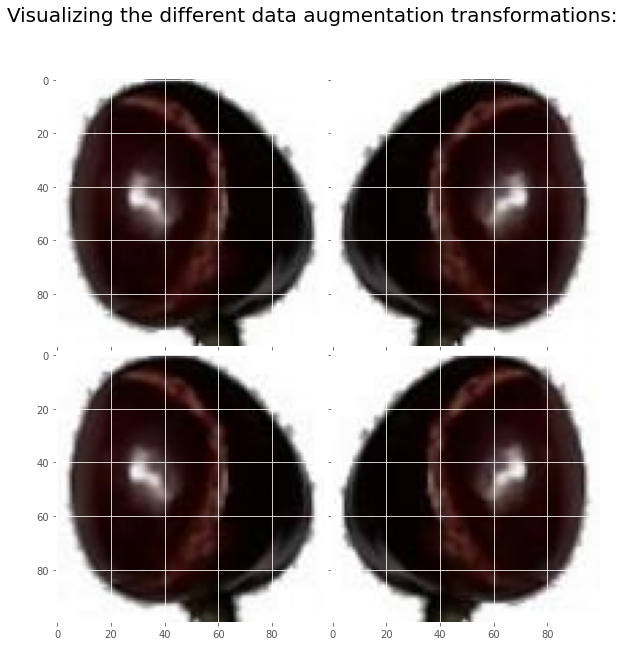

In [30]:
fig = plt.figure(figsize=(10., 10.))
fig.suptitle("Visualizing the different data augmentation transformations:  ", fontsize = 20)

grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2
                 , 2),
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, images):
    ax.imshow(im)
plt.show()

### Checkpoint


In [150]:
#!rm -rf /content/fruits-360_dataset/fruits-360/models/

In [151]:
#!mkdir /content/fruits-360_dataset/fruits-360/models/ # create directory where the models will be saved


In [152]:
checkpoint = keras.callbacks.ModelCheckpoint(
    '/content/fruits-360_dataset/fruits-360/models/VGG16_v1_{epoch:02d}_{val_accuracy:.3f}.h5',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [153]:
alpha = 1e-5
droprate = 0.2 # defined drop rate
size_inner=1024

model = build_model(
    alpha=alpha,
    size_inner=size_inner,
    droprate=droprate
)

history = model.fit(train_ds_aug, epochs=20
, validation_data=val_ds_aug,callbacks=[checkpoint])


Epoch 1/27
1694/1694 [==============================] - 236s 139ms/step - loss: 2.5520 - accuracy: 0.4083 - val_loss: 0.9227 - val_accuracy: 0.7586
Epoch 2/27
1694/1694 [==============================] - 235s 139ms/step - loss: 0.6596 - accuracy: 0.8089 - val_loss: 0.3722 - val_accuracy: 0.8948
Epoch 3/27
1694/1694 [==============================] - 232s 137ms/step - loss: 0.3109 - accuracy: 0.9065 - val_loss: 0.2421 - val_accuracy: 0.9293
Epoch 4/27
1694/1694 [==============================] - 233s 138ms/step - loss: 0.1930 - accuracy: 0.9402 - val_loss: 0.1945 - val_accuracy: 0.9397
Epoch 5/27
1694/1694 [==============================] - 233s 137ms/step - loss: 0.1346 - accuracy: 0.9581 - val_loss: 0.1700 - val_accuracy: 0.9492
Epoch 6/27
1694/1694 [==============================] - 236s 139ms/step - loss: 0.1011 - accuracy: 0.9679 - val_loss: 0.1250 - val_accuracy: 0.9596
Epoch 7/27
1694/1694 [==============================] - 233s 138ms/step - loss: 0.0825 - accuracy: 0.9741 - val_

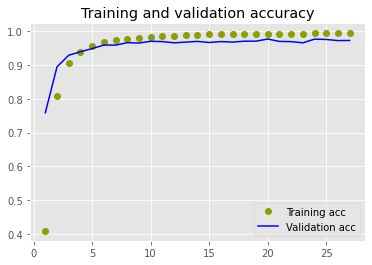

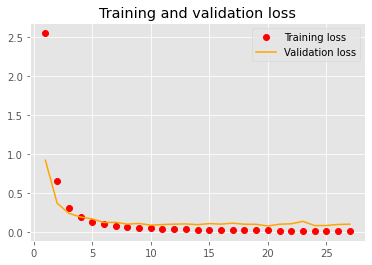

In [154]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training acc' , color='#8ba000')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()



plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss' , color='red')
plt.plot(epochs, val_loss, 'b', label='Validation loss',color='orange')
plt.title('Training and validation loss')
plt.legend()



plt.show()

The curves here are much more close now, this quite an improvement in comparasion of the curves produced before, now we can be sure the model isn't overfitting

After quite a long execution time, eventually the best accuracy achieved is $97.47\%$, let's measure now the accuracy on the test dataset.


In [171]:
model = tf.keras.models.load_model('/content/fruits-360_dataset/fruits-360/models/VGG16_v1_06_0.960.h5')


In [172]:
model.evaluate(test_ds)


709/709 [==============================] - 19s 27ms/step - loss: 0.1783 - accuracy: 0.9554


[0.1782984435558319, 0.9553949236869812]

$96.79\%$!🍇  That's quite a bump in accuracy, also this accuracy obtained with the test dataset is fairly close to the accuracy of the validation dataset.  

The loss is also very low at $[0.200]$ this shows that a significant improvement is duable with the right hyperparameter tuning and fine tuning. VGG16 performed exceptionally well here, improving the accuracy score of XCeption quite a bit.

## Prediction Test with VGG16 

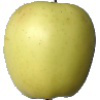

In [173]:
path = '/content/fruits-360_dataset/fruits-360/Test/Apple Golden 2/321_100.jpg'
img = load_img(path, target_size=(100, 100))
img

In [174]:
x = np.array(img)
X = np.array([x])
X.shape
X = preprocess_input(X)


In [175]:
pred = model.predict(X)


In [176]:
d = dict(zip(test_ds.class_indices, pred[0]))
sorted(d.items(), key=lambda x: x[1], reverse=True)

[('Apple Golden 2', 0.99953616),
 ('Apple Golden 3', 0.9974611),
 ('Apple Red 2', 0.9279133),
 ('Apple Granny Smith', 0.92318994),
 ('Grapefruit White', 0.3049515),
 ('Grape Blue', 0.012708694),
 ('Pear Kaiser', 0.012318747),
 ('Apple Golden 1', 0.011153781),
 ('Peach Flat', 0.005295918),
 ('Lemon', 0.00509108),
 ('Apple Braeburn', 0.004921997),
 ('Apricot', 0.0046959133),
 ('Pear', 0.0027355198),
 ('Apple Red 3', 0.0020593305),
 ('Plum 3', 0.0010084242),
 ('Potato White', 0.00015708164),
 ('Apple Red Yellow 2', 0.00012916443),
 ('Apple Pink Lady', 0.00012729029),
 ('Grape White 4', 7.357373e-05),
 ('Orange', 4.1442123e-05),
 ('Peach', 4.132846e-05),
 ('Papaya', 3.5807345e-05),
 ('Pomelo Sweetie', 1.8312201e-05),
 ('Cucumber Ripe 2', 7.163155e-06),
 ('Walnut', 5.759543e-06),
 ('Nectarine Flat', 5.015964e-06),
 ('Grape Pink', 4.7608014e-06),
 ('Nectarine', 3.9663732e-06),
 ('Avocado', 1.8241709e-06),
 ('Quince', 1.6909322e-06),
 ('Grape White 2', 1.3322998e-06),
 ('Pomegranate', 1.25044